# Flexibility Around Cost

## Imports and Definitions

In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as display
%matplotlib inline

from lib.StrategicModel import StrategicModel
from addons.Flexibility import LinearFlexibleStrategicModel
import DataGeneration as data
# import Visualization

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)

PATH = "./results/flexibility"
if not os.path.exists(PATH):
    os.makedirs(PATH)

## Data Generation

In [2]:
x_dim = 2
n_samples = 300
X, Y = data.gen_custom_normal_data(x_dim, n_samples, torch.Tensor([0.5, 0]), torch.Tensor([0.1, 1]), torch.Tensor([-0.5, 0]), torch.Tensor([0.1, 1]))
positive = X[Y == 1]
negative = X[Y == -1]
pd.DataFrame(positive.numpy()).to_csv(f"{PATH}/positive.csv")
pd.DataFrame(negative.numpy()).to_csv(f"{PATH}/negative.csv")
X, Y, Xval, Yval, Xtest, Ytest = data.split_validation_test(X, Y)

## Training

In [3]:
epochs = 16
batch_size = 16
reg = 0.001

v_0 = torch.tensor([0.5, 0.5])
v_best = torch.tensor([1, 0])

In [4]:
init_time = time.time()

results = {}

# Non-strategic classification - Benchmark
print("---------- Training the benchmark model (non-strategically with v=v_0) ----------")
model_name = "benchmark"
non_strategic_model = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v_0}, strategic=False)
non_strategic_model.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 1e-1}, epochs=epochs, verbose="epochs", save_progress=True, path=PATH, model_name=model_name)

w = non_strategic_model.w.data
b = non_strategic_model.b.data
v = v_0
acc = non_strategic_model.evaluate(Xtest, Ytest, strategic_data=False)
results["benchmark"] = {"w0": w[0].item(), "w1": w[1].item(), "b": b.item(), "v0": v[0].item(), "v1": v[1].item(), "acc": acc}
pd.DataFrame(results).to_csv(f"{PATH}/results.csv")

# Strategic classification - Oracle
print("---------- Training the oracle model (strategically with v=v_best) ----------")
model_name = "oracle"
strategic_model_oracle = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v_best}, strategic=True)
strategic_model_oracle.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 1e-1}, epochs=epochs, verbose="epochs", save_progress=True, path=PATH, model_name=model_name)

w = strategic_model_oracle.w.data
b = strategic_model_oracle.b.data
v = v_best
acc = strategic_model_oracle.evaluate(Xtest, Ytest, strategic_data=True)
results["oracle"] = {"w0": w[0].item(), "w1": w[1].item(), "b": b.item(), "v0": v[0].item(), "v1": v[1].item(), "acc": acc}
pd.DataFrame(results).to_csv(f"{PATH}/results.csv")

# Strategic classification - Naive
print("---------- Training the naive model (strategically with v=v_0) ----------")
model_name = "naive"
strategic_model_naive = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v_0}, strategic=True)
strategic_model_naive.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 1e-1}, epochs=epochs, verbose="epochs", save_progress=True, path=PATH, model_name=model_name)

# Evaluate the naive model with v = v_best
strategic_model_naive = StrategicModel(x_dim, batch_size, cost_fn="linear", cost_const_kwargs={"v": v_best}, strategic=True)
strategic_model_naive.load_model(PATH, model_name)

w = strategic_model_naive.w.data
b = strategic_model_naive.b.data
v = v_0
acc = strategic_model_naive.evaluate(Xtest, Ytest, strategic_data=True)
results["naive"] = {"w0": w[0].item(), "w1": w[1].item(), "b": b.item(), "v0": v[0].item(), "v1": v[1].item(), "acc": acc}
pd.DataFrame(results).to_csv(f"{PATH}/results.csv")

# Strategic classification - SERM
print("---------- Training the SERM model (strategically and flexible with v_init=v_0) ----------")
model_name = "SERM"
strategic_model_SERM = LinearFlexibleStrategicModel(x_dim, batch_size, v_init=v_0, reg=reg, strategic=True)
strategic_model_SERM.fit(X, Y, Xval, Yval, opt_class=torch.optim.Adam, opt_kwargs={"lr": 1e-1}, epochs=epochs, verbose="epochs", save_progress=True, path=PATH, model_name=model_name)

w = strategic_model_SERM.w.data
b = strategic_model_SERM.b.data
v = strategic_model_SERM.v.data
v /= torch.norm(v)
acc = strategic_model_SERM.evaluate(Xtest, Ytest, strategic_data=True)
results["SERM"] = {"w0": w[0].item(), "w1": w[1].item(), "b": b.item(), "v0": v[0].item(), "v1": v[1].item(), "acc": acc}
pd.DataFrame(results).to_csv(f"{PATH}/results.csv")

final_time = time.time()
total_time = final_time - init_time
print(f"Test took {total_time / 60} minutes ({total_time} seconds).")

---------- Training the benchmark model (non-strategically with v=v_0) ----------
Starting epoch 001 / 016.
Ended epoch 001 / 016 | time: 000 sec | loss: 0.20223 | error: 0.00000
Model saved to ./results/flexibility/benchmark_model.pt.
Starting epoch 002 / 016.
Ended epoch 002 / 016 | time: 000 sec | loss: 0.02398 | error: 0.00000
Starting epoch 003 / 016.
Ended epoch 003 / 016 | time: 000 sec | loss: 0.01130 | error: 0.00000
Starting epoch 004 / 016.
Ended epoch 004 / 016 | time: 000 sec | loss: 0.00801 | error: 0.00000
Starting epoch 005 / 016.
Ended epoch 005 / 016 | time: 000 sec | loss: 0.00722 | error: 0.00000
Ending training due to 4 consecutive epochs without improvement in validation accuracy.
Total training time: 0.3487980365753174 seconds.
Model loaded from ./results/flexibility/benchmark_model.pt.
---------- Training the oracle model (strategically with v=v_best) ----------
Starting epoch 001 / 016.
Ended epoch 001 / 016 | time: 002 sec | loss: 0.24599 | error: 0.00000
Mode

## Show Results

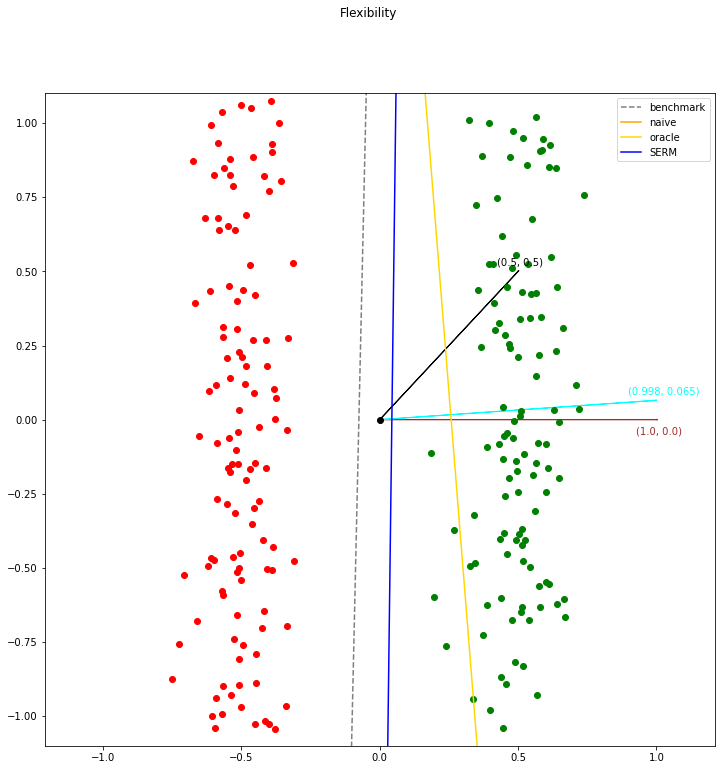

In [5]:
results = pd.read_csv("results/flexibility/results.csv")
benchmark = results["benchmark"].to_list()
oracle = results["oracle"].to_list()
naive = results["naive"].to_list()
SERM = results["SERM"].to_list()

positive = pd.read_csv("results/flexibility/positive.csv")
positive_points_x = positive['0'].to_list()
positive_points_y = positive['1'].to_list()
negative = pd.read_csv("results/flexibility/negative.csv")
negative_points_x = negative['0'].to_list()
negative_points_y = negative['1'].to_list()

fig, ax = plt.subplots(figsize=(12, 12))
_ = fig.suptitle("Flexibility")

_ = ax.plot(0, 0, 'ok')
_ = ax.plot(positive_points_x, positive_points_y, 'og')
_ = ax.plot(negative_points_x, negative_points_y, 'or')

_ = ax.arrow(0, 0, benchmark[3], benchmark[4], color="black")
_ = ax.text(benchmark[3] - 0.075, benchmark[4] + 0.02, f"({benchmark[3]}, {benchmark[4]})", color="black")
_ = ax.arrow(0, 0, oracle[3], oracle[4], color="brown")
_ = ax.text(oracle[3] - 0.075, oracle[4] - 0.05, f"({oracle[3]}, {oracle[4]})", color="brown")
_ = ax.arrow(0, 0, SERM[3], SERM[4], color='cyan')
_ = ax.text(SERM[3] - 0.1, SERM[4] + 0.02, f"({SERM[3]:.3f}, {SERM[4]:.3f})", color="cyan")

_ = ax.set_ylim(-1.1, 1.1)

x = np.linspace(-1.1, 1.1, 100)
def plot_line(w0, w1, b, linestyle, color, label):
    if w1 == 0:
        ax.axvline(-b / w0, linestyle=linestyle, color=color, label=label)
    else:
        ax.plot(x, -(w0 / w1) * x - b / w1, linestyle=linestyle, color=color, label=label)

plot_line(benchmark[0], benchmark[1], benchmark[2], linestyle="--", color="tab:gray", label="benchmark")
plot_line(naive[0], naive[1], naive[2], linestyle="-", color="orange", label="naive")
plot_line(oracle[0], oracle[1], oracle[2], linestyle="-", color="gold", label="oracle")
plot_line(SERM[0], SERM[1], SERM[2], linestyle="-", color="blue", label="SERM")
_ = ax.legend()